<a href="https://colab.research.google.com/github/mdhornstein/computer-vision-interpretability-paleontology-v0/blob/main/notebooks/00_prepare_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Fossil Image Dataset (FID) for classification experiments

In [1]:
import os
import random
import shutil
import requests
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
PROJECT_DIR = "/content/drive/MyDrive/cv_paleontology"
DATA_DIR = os.path.join(PROJECT_DIR, "data")

os.makedirs(DATA_DIR, exist_ok=True)

In [2]:
# --- Setup: clone repo if running in Colab ---

# Change this to your repo
REPO_URL = "https://github.com/mdhornstein/computer-vision-interpretability-paleontology-v0.git"
REPO_NAME = REPO_URL.split("/")[-1].replace(".git", "")

if "google.colab" in str(get_ipython()):
    if not os.path.exists(REPO_NAME):
        !git clone {REPO_URL}
    %cd {REPO_NAME}/notebook
    !git pull
    !pwd

Cloning into 'computer-vision-interpretability-paleontology-v0'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), done.
Resolving deltas: 100% (1/1), done.
/content/computer-vision-interpretability-paleontology-v0
Already up to date.
/content/computer-vision-interpretability-paleontology-v0


In [11]:
# --- Config ---
# Which fossil groups to include? Adjust as needed
CLASSES = ["trilobite", "ammonoid"]
VAL_SPLIT = 0.2
SEED = 42

In [5]:
# Paths
zip_path = os.path.join(DATA_DIR, "reduced-FID.zip")
extract_dir = os.path.join(DATA_DIR, "reduced-FID")

In [7]:
# Download and extract the dataset from Zenodo ---
!wget -O "{DATA_DIR}/reduced-FID.zip" "https://zenodo.org/records/6333970/files/reduced-FID.zip?download=1"

--2025-09-25 02:31:29--  https://zenodo.org/records/6333970/files/reduced-FID.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1819654497 (1.7G) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/cv_paleontology_v0/data/reduced-FID.zip’

/content/drive/MyDr 100%[===================>]   1.69G  26.2MB/s    in 4m 12s  

2025-09-25 02:35:42 (6.88 MB/s) - ‘/content/drive/MyDrive/cv_paleontology_v0/data/reduced-FID.zip’ saved [1819654497/1819654497]



In [8]:
# Unzip into the target folder
!unzip -o "{zip_path}" -d "{DATA_DIR}" > fid_out.log 2> fid_err.log

In [9]:
# Remove the ZIP file after extraction
!rm "{zip_path}"

In [10]:
!ls {DATA_DIR}/reduced-FID

 agnatha	  conodont	   marine_reptile   sauropodomorph
 ammonoid	  coral		   myriapod	    shark_teeth
 amphibian	  crinoid	   nautiloid	    snake
 angiosperm	  crocodylomorph   ophiuroid	    sponge
 avialae	  crustacean	   ornithischian    spore_or_pollen
 belemnite	  echinoid	   osteichthyes     starfish
 bivalve	  foraminifer	   ostracod	    stromatolite
 blastoid	  gastropod	   petrified_wood  'Terms of access.docx'
 bone_fragment	  graptolite	   placoderms	    theropod
 brachiopod	  gymnosperm	   pteridophyte     trace_fossil
 bryozoan	  insect	   pterosaurs	    trilobite
 chelicerate	  mammal	   radiolarian	    turtle
 chondrichthyes   mammal_teeth	   reptile_teeth


In [11]:
# List the first 10 files in the 'agnatha' directory of the extracted dataset
!ls reduced-FID/agnatha/ | head

045.jpg
061025.lamprey2-200.jpg
0D4AAOSwnBRgNsn~s-l1600.jpg
100.tumblr_msal0qg4oo1sh1ns2o2_500 (2).jpg
102.pict0155.jpg
102.tully_monster.jpg
102.tumblr_mn5i3ng5ss1spmwbxo1_400.jpg
103.48320371757_f14a613401_m.jpg
106.img_20200811_170136.jpg.ffaacadf2fa3b4a173b996acbbd58163.jpg
107.acd494bf0b97b6706cf53918be87cb2e.jpg


In [12]:
# --- Step 2: Prepare dataset for classification ---
# This cell splits the dataset into training and validation sets
# for the specified classes and organizes them into a new directory structure.

# Paths
SOURCE_DIR = Path(DATA_DIR) / "reduced-FID"

experiment_name = "exp1_trilobite_ammonoid"
TARGET_DIR = Path(DATA_DIR) / experiment_name

# Clean up any old data dir if rerunning
if TARGET_DIR.exists():
    shutil.rmtree(TARGET_DIR)

# Create train/val dirs
for split in ["train", "val"]:
    (TARGET_DIR / split).mkdir(parents=True, exist_ok=True)

# Split ratio
train_ratio = 0.8

# Go through each clade directory
for clade_dir in SOURCE_DIR.iterdir():
    if clade_dir.is_dir():
        clade_name = clade_dir.name
        # Only process specified classes
        if clade_name in CLASSES:
            images = list(clade_dir.glob("*"))
            random.shuffle(images)

            split_idx = int(len(images) * train_ratio)
            train_imgs = images[:split_idx]
            val_imgs = images[split_idx:]

            # Create clade subdirs
            (TARGET_DIR / "train" / clade_name).mkdir(parents=True, exist_ok=True)
            (TARGET_DIR / "val" / clade_name).mkdir(parents=True, exist_ok=True)

            # Copy files
            for img in train_imgs:
                shutil.copy(img, TARGET_DIR / "train" / clade_name / img.name)
            for img in val_imgs:
                shutil.copy(img, TARGET_DIR / "val" / clade_name / img.name)

print("✅ Dataset prepared at:", TARGET_DIR.resolve())

✅ Dataset prepared at: /content/drive/MyDrive/cv_paleontology_v0/data/exp1_trilobite_ammonoid


In [13]:
# --- Step 3: Verify dataset preparation ---
# Count images in train and val directories and display examples

print("\n--- Dataset Summary ---")

for split in ["train", "val"]:
    split_dir = TARGET_DIR / split
    print(f"\n{split.capitalize()} set:")
    for class_dir in split_dir.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            images = list(class_dir.glob("*"))
            num_images = len(images)
            print(f"  {class_name}: {num_images} images")

            # Print example image names (first 5)
            print("    Example images:")
            for i, img_path in enumerate(images[:5]):
                print(f"      - {img_path.name}")


--- Dataset Summary ---

Train set:
  ammonoid: 960 images
    Example images:
      - 299.huge_ammonite_fossil_disk_from_1612248515_5e2830d5_progressive_thumbnail.jpg
      - fossil-ammonite-upper-early-cretaceo.jpg
      - bZoAAOSwGTNfJNl5s-l1600.jpg
      - 350.lf.jpg
      - D8QAAOSw7-peRXmQs-l1600.jpg
  trilobite: 960 images
    Example images:
      - 51aIo2kYGCL.jpg
      - 9yoAAOSwOzleIiaps-l1600.jpg
      - 8JMAAOSwONte-G8Cs-l1600.jpg
      - il_340x270.1754736308_fj5w.jpg
      - 2gsAAOSwA3dYkkBgs-l1600.jpg

Val set:
  ammonoid: 240 images
    Example images:
      - ammonite+fossilwnEAAOSwNw1ePBL1s-l1600.jpg
      - 9hIAAOSwNydce1LRs-l1600.jpg
      - 9kUAAOSw-RFad19vs-l1600.jpg
      - ammonite+fossilAQkAAOSwyPlc3ygFs-l1600.jpg
      - 342.$_1.jpg
  trilobite: 240 images
    Example images:
      - p129-489.png
      - s892199138901920866_p6331_i134_w800.jpeg
      - grand-trilobite-fossile.jpg
      - FvUAAOSwIe1gI8dss-l1600.jpg
      - 60.http%3a%2f%2fassets.catawiki.nl%


--- Example Images ---

Train set examples:
  ammonoid:


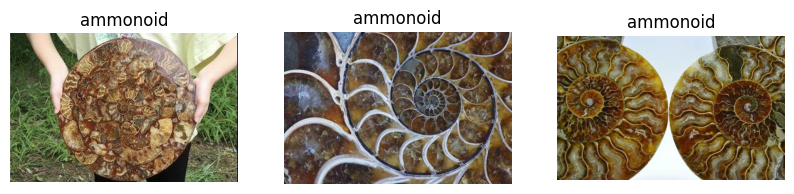

  trilobite:


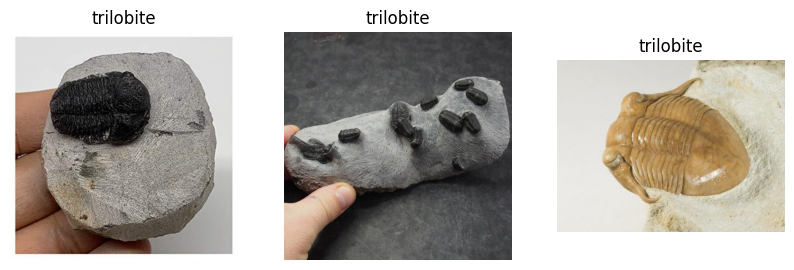


Val set examples:
  ammonoid:


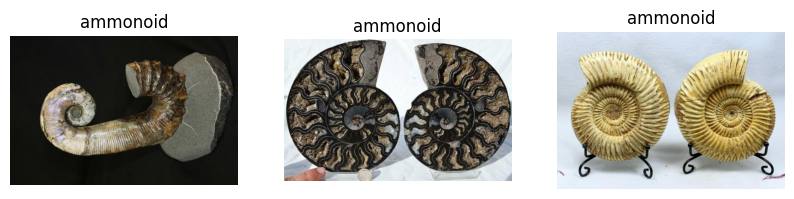

  trilobite:


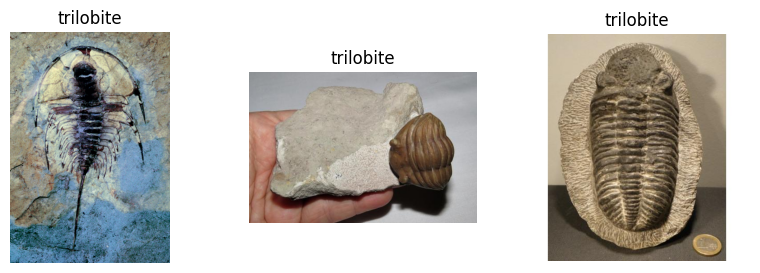

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

# --- Step 4: Display example images ---
# Display a few example images from each class in the train and val sets

print("\n--- Example Images ---")

num_examples_per_class = 3

for split in ["train", "val"]:
    split_dir = TARGET_DIR / split
    print(f"\n{split.capitalize()} set examples:")
    for class_dir in split_dir.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            images = list(class_dir.glob("*"))

            print(f"  {class_name}:")
            plt.figure(figsize=(10, 3))
            for i, img_path in enumerate(images[:num_examples_per_class]):
                try:
                    img = Image.open(img_path)
                    plt.subplot(1, num_examples_per_class, i + 1)
                    plt.imshow(img)
                    plt.title(class_name)
                    plt.axis("off")
                except Exception as e:
                    print(f"    Could not load image {img_path.name}: {e}")
                    continue
            plt.show()